In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
import itertools
import seaborn as sn
from textblob import TextBlob
import glob

# warning
import warnings
warnings.filterwarnings("ignore")

### Data wrangling & cleaning

In [3]:
df = pd.read_csv('../data/final_data.csv')
df.head(3)

,date,full_text,geo,truncated,display_text_range,user,tweet_id,entities,possibly_sensitive,longitude,...,yoursel,youth,youtube,yrxltdq,yummy,yumyum,yup,zero,zoom,sentiment
0,2020-03-30,Definitely making a routine to stop from going...,"[41.42362498, -122.39264801]",False,"[0, 239]","{'id': 988896150571790336, 'id_str': '98889615...",1244710975422574592,"{'hashtags': [], 'symbols': [], 'user_mentions...",False,-122.392648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0625
1,2020-03-30,This is my 'self-isolating' face. #quarantine ...,"[34.1722, -118.378]",False,"[0, 140]","{'id': 1008423932267921408, 'id_str': '1008423...",1244710063589089281,"{'hashtags': [{'text': 'quarantine', 'indices'...",False,-118.378000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2,2020-03-30,Corona virus testing and treatment is availabl...,"[33.97977, -118.18884]",False,"[0, 233]","{'id': 107183997, 'id_str': '107183997', 'name...",1244708953994469377,"{'hashtags': [], 'symbols': [], 'user_mentions...",False,-118.188840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4000


In [4]:
irrelevant_cols = ['full_text', 'geo', 'display_text_range', 'user', 'tweet_id',
       'entities', 'longitude', 'latitude', 'state', 'preprocess_full_text']

In [5]:
relevant_cols = df.drop(columns=irrelevant_cols)
relevant_cols.head(2)

,date,truncated,possibly_sensitive,county,retail_rec,groc_pharm,parks,transit,workplaces,residential,...,yoursel,youth,youtube,yrxltdq,yummy,yumyum,yup,zero,zoom,sentiment
0,2020-03-30,False,False,Siskiyou County,-33.0,-12.0,-2.0,-12.0,-40.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0625
1,2020-03-30,False,False,Los Angeles County,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000


In [6]:
# Length before dropping missing values
len(relevant_cols)

17531

In [7]:
# Drop rows with NaN values
no_na = relevant_cols.dropna()
len(no_na)

15923

In [8]:
political = pd.read_csv('../data/political_party_bycounty.csv')
political.drop(columns=['Unnamed: 0'], inplace=True)
political.head(2)

,county,biden_votes,biden_percent,trump_votes,trump_percent,biden_yes
0,Alameda County,617486,80.2,136238,17.7,1
1,Alpine County,473,64.7,238,32.6,1


In [9]:
age = [['Los Angeles County',12.7],['Riverside County',11.1],['Orange County',11.5],['Santa Clara County',11.6],['Alameda County',12.1],['Sacramento County',12.0],['San Bernardino County',12.3],['Contra Costa County',9.8],['San Diego County',13.4],['Ventura County',11.0],['San Mateo County',10.3],['Sonoma County',10.2],['Santa Barbara County',12.6],['Santa Cruz County',11.5],['Monterey County',11.8],['San Luis Obispo County',10.8],['Kern County',12.5],['Fresno County',12.5],['Placer County',8.3],['San Joaquin County',11.1]]

age_df = pd.DataFrame(age, columns = ['county', 'percent'])
merged = no_na.merge(age_df)
merged.head(2)

,date,truncated,possibly_sensitive,county,retail_rec,groc_pharm,parks,transit,workplaces,residential,...,youth,youtube,yrxltdq,yummy,yumyum,yup,zero,zoom,sentiment,percent
0,2020-03-30,False,False,Los Angeles County,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.7
1,2020-03-30,False,False,Los Angeles County,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,12.7


In [10]:
# Merge with no_na DF

merged = merged.merge(political)
merged.head(2)

,date,truncated,possibly_sensitive,county,retail_rec,groc_pharm,parks,transit,workplaces,residential,...,yup,zero,zoom,sentiment,percent,biden_votes,biden_percent,trump_votes,trump_percent,biden_yes
0,2020-03-30,False,False,Los Angeles County,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,...,0.0,0.0,0.0,0.0,12.7,3024321,71.0,1143687,26.9,1
1,2020-03-30,False,False,Los Angeles County,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,...,0.0,0.0,0.0,0.4,12.7,3024321,71.0,1143687,26.9,1


In [11]:
# Length after dropping missing values & merging DFs
len(no_na), len(merged)

(15923, 15608)

In [12]:
merged = merged.groupby('county').filter(lambda x : len(x)>75)
merged.head(2)

,date,truncated,possibly_sensitive,county,retail_rec,groc_pharm,parks,transit,workplaces,residential,...,yup,zero,zoom,sentiment,percent,biden_votes,biden_percent,trump_votes,trump_percent,biden_yes
0,2020-03-30,False,False,Los Angeles County,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,...,0.0,0.0,0.0,0.0,12.7,3024321,71.0,1143687,26.9,1
1,2020-03-30,False,False,Los Angeles County,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,...,0.0,0.0,0.0,0.4,12.7,3024321,71.0,1143687,26.9,1


In [13]:
# One hot encode categorical columns
dummy_cols = ['county', 'truncated', 'possibly_sensitive']
ohe_df = pd.get_dummies(merged, drop_first=True, columns=dummy_cols)
ohe_df.head(2)

,date,retail_rec,groc_pharm,parks,transit,workplaces,residential,public,polarity,aad,...,county_San Joaquin County,county_San Luis Obispo County,county_San Mateo County,county_Santa Barbara County,county_Santa Clara County,county_Santa Cruz County,county_Sonoma County,county_Ventura County,truncated_True,possibly_sensitive_True
0,2020-03-30,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,-42.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-30,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,-42.0,0.4,0.0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Add county back
ohe_df['county'] = merged['county']
ohe_df.head(1)

,date,retail_rec,groc_pharm,parks,transit,workplaces,residential,public,polarity,aad,...,county_San Luis Obispo County,county_San Mateo County,county_Santa Barbara County,county_Santa Clara County,county_Santa Cruz County,county_Sonoma County,county_Ventura County,truncated_True,possibly_sensitive_True,county
0,2020-03-30,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,-42.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,Los Angeles County


In [15]:
grouped = ohe_df.groupby(['county','date']).mean()
grouped.head(2)

retail_rec  groc_pharm  parks  transit  workplaces  \
county         date                                                             
Alameda County 2020-03-30       -48.0       -23.0   -1.0    -71.0       -64.0   
               2020-04-01       -48.0       -18.0    0.0    -70.0       -65.0   

                           residential  public  polarity  aad  abc  ...  \
county         date                                                 ...   
Alameda County 2020-03-30         27.0  -51.50  0.233333  0.0  0.0  ...   
               2020-04-01         28.0  -50.25  0.221645  0.0  0.0  ...   

                           county_San Joaquin County  \
county         date                                    
Alameda County 2020-03-30                        0.0   
               2020-04-01                        0.0   

                           county_San Luis Obispo County  \
county         date                                        
Alameda County 2020-03-30                            0.0   
               2020-04-01                            0.0   

                           county_San Mateo County  \
county         date                                  
Alameda County 2020-03-30                      0.0   
               2020-04-01                      0.0   

                           county_Santa Barbara County  \
county         date                                      
Alameda County 2020-03-30                          0.0   
               2020-04-01                          0.0   

                           county_Santa Clara County  \
county         date                                    
Alameda County 2020-03-30                        0.0   
               2020-04-01                        0.0   

                           county_Santa Cruz County  county_Sonoma County  \
county         date                                                         
Alameda County 2020-03-30                       0.0                   0.0   
               2020-04-01                       0.0                   0.0   

                           county_Ventura County  truncated_True  \
county         date                                                
Alameda County 2020-03-30                    0.0             0.0   
               2020-04-01                    0.0             0.0   

                           possibly_sensitive_True  
county         date                                 
Alameda County 2020-03-30                      0.0  
               2020-04-01                      1.0  

[2 rows x 2322 columns]

In [16]:
len(grouped)

2264

In [17]:
reset_ind = grouped.reset_index()
reset_ind.drop(columns=['county'], inplace=True)

In [18]:
final_df = reset_ind
final_df.head(2)

,date,retail_rec,groc_pharm,parks,transit,workplaces,residential,public,polarity,aad,...,county_San Joaquin County,county_San Luis Obispo County,county_San Mateo County,county_Santa Barbara County,county_Santa Clara County,county_Santa Cruz County,county_Sonoma County,county_Ventura County,truncated_True,possibly_sensitive_True
0,2020-03-30,-48.0,-23.0,-1.0,-71.0,-64.0,27.0,-51.50,0.233333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-04-01,-48.0,-18.0,0.0,-70.0,-65.0,28.0,-50.25,0.221645,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
mobility_columns = list(final_df.columns)[1:8]
mobility_columns

['retail_rec',
 'groc_pharm',
 'parks',
 'transit',
 'workplaces',
 'residential',
 'public']

In [21]:
# Convert date column to pd.DateTime object
final_df['date'] = pd.to_datetime(final_df['date'])
type(final_df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [23]:
def get_accuracy(pred_y, actual_y, margin):
    accuracies = []
    for i in range(len(pred_y)):
        if (abs(pred_y[i] - actual_y[i]) <= margin):
            accuracies.append(1)
        else:
            accuracies.append(0)
    return sum(accuracies)/len(accuracies)

In [24]:
def split_df_by_date(df):
    
    X_train = df[df['date'] < pd.to_datetime('2020-06-15')]
    
    X_test = df[df['date'] >= pd.to_datetime('2020-06-15')]
    
    return (X_train, X_test)

In [25]:
def get_X_y_train_test(df_train, df_test, cols_to_use, mobility):
    
    X_train = df_train.loc[:, cols_to_use]
    
    y_train = np.array(df_train[mobility])
    
    X_test = df_test.loc[:, cols_to_use]
    
    y_test = np.array(df_test[mobility])
    
    return (X_train, X_test, y_train, y_test)

In [27]:
final_df['is_weekend'] = final_df['date'].dt.dayofweek >= 5
final_df['is_weekend'] = final_df['is_weekend'].astype(int)
final_df.head(2)

,date,retail_rec,groc_pharm,parks,transit,workplaces,residential,public,polarity,aad,...,county_San Luis Obispo County,county_San Mateo County,county_Santa Barbara County,county_Santa Clara County,county_Santa Cruz County,county_Sonoma County,county_Ventura County,truncated_True,possibly_sensitive_True,is_weekend
0,2020-03-30,-48.0,-23.0,-1.0,-71.0,-64.0,27.0,-51.50,0.233333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2020-04-01,-48.0,-18.0,0.0,-70.0,-65.0,28.0,-50.25,0.221645,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


## Construct the model

#### Created a method to construct model given:
1. The set of features to use in the model 
2. The type of mobility to predict
3. The permitted margin for error
    - A prediction is *accurate* if the actual value falls in the range [prediction - margin, prediction + margin].

In [117]:
def accuracy_for_specific_features(df, features, mobility_type='public', margin=5):
    
    before_mid_june, mid_june_onwards = split_df_by_date(df)

    X_train, X_test, y_train, y_test = get_X_y_train_test(before_mid_june, mid_june_onwards, features, mobility=mobility_type)

    ### Build the linear model

    lm = linear_model.LinearRegression()
    lm.fit(X_train, y_train)

    y_pred = lm.predict(X_test)

#     residuals = y_pred - y_test
#     plt.scatter(y_pred, residuals)
#     plt.show()

    return get_accuracy(y_pred, y_test, margin)
    

In [99]:
features = list(final_df.columns)[-29:]
features

['sentiment',
 'percent',
 'biden_votes',
 'biden_percent',
 'trump_votes',
 'trump_percent',
 'biden_yes',
 'county_Contra Costa County',
 'county_Fresno County',
 'county_Kern County',
 'county_Los Angeles County',
 'county_Monterey County',
 'county_Orange County',
 'county_Placer County',
 'county_Riverside County',
 'county_Sacramento County',
 'county_San Bernardino County',
 'county_San Diego County',
 'county_San Joaquin County',
 'county_San Luis Obispo County',
 'county_San Mateo County',
 'county_Santa Barbara County',
 'county_Santa Clara County',
 'county_Santa Cruz County',
 'county_Sonoma County',
 'county_Ventura County',
 'truncated_True',
 'possibly_sensitive_True',
 'is_weekend']

In [110]:
accuracy_for_specific_features(final_df, features, mobility_type='public', margin=11)

0.8441843452816387

In [111]:
accuracy_for_specific_features(final_df, features, mobility_type='residential', margin=11)

0.9853694220921726

In [112]:
accuracy_for_specific_features(final_df, features, mobility_type='public', margin=15)

0.9473299195318216

In [114]:
accuracy_for_specific_features(final_df, features, mobility_type='residential', margin=15)

1.0

In [115]:
margins = np.linspace(start=0, stop=20)
accuracies_public = np.array([accuracy_for_specific_features(final_df, features, mobility_type='public', margin=m) for m in margins])
accuracies_residential = np.array([accuracy_for_specific_features(final_df, features, mobility_type='residential', margin=m) for m in margins])

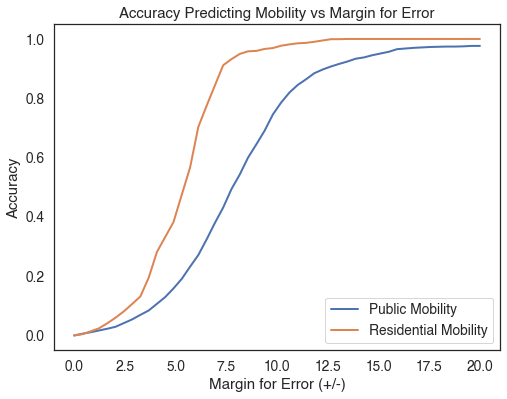

In [116]:
plt.figure(figsize=(8, 6))
sn.set(font_scale=1.25, style='white', font='Helvetica')
sn.lineplot(x=margins, y=accuracies_public, linewidth=2)
sn.lineplot(x=margins, y=accuracies_residential, linewidth=2)
plt.title('Accuracy Predicting Mobility vs Margin for Error')
plt.xlabel('Margin for Error (+/-)')
plt.ylabel('Accuracy')
plt.legend(['Public Mobility', 'Residential Mobility'])
plt.show()